In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [ ]:
from PIL import Image
import glob
IMG_SIZE = 160
 
def get_all_images(dir):
  images = []
  for image in glob.iglob(f'{dir}/*'):
    temp = np.asarray(Image.open(image)).astype(np.float32)
    temp = temp/127.5 - 1
    temp = tf.image.resize(temp, (IMG_SIZE, IMG_SIZE))
    images.append(temp)
  return np.array(images)

In [ ]:
!ls dataset/cotton/val

'diseased cotton leaf'	 'fresh cotton leaf'
'diseased cotton plant'  'fresh cotton plant'


In [ ]:
# diseased leaves
dis_train = get_all_images('dataset/cotton/train/diseased cotton leaf')
dis_test = get_all_images('dataset/cotton/test/diseased cotton leaf')
dis_val = get_all_images('dataset/cotton/val/diseased cotton leaf')

# fresh leaves
fresh_train = get_all_images('dataset/cotton/train/fresh cotton leaf')
fresh_test = get_all_images('dataset/cotton/test/fresh cotton leaf')
fresh_val = get_all_images('dataset/cotton/val/fresh cotton leaf')

In [ ]:
class_names = ['diseased', 'fresh']

#train
train_images = np.concatenate((dis_train, fresh_train))
train_labels = np.array([0]*len(dis_train) + [1]*len(fresh_train))
train = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

#test
test_images = np.concatenate((dis_test, fresh_test))
test_labels = np.array([0]*len(dis_test) + [1]*len(fresh_test))
test = tf.data.Dataset.from_tensor_slices((test_images))

#val
val_images = np.concatenate((dis_val, fresh_val))
val_labels = np.array([0]*len(dis_val) + [1]*len(fresh_val))
val = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

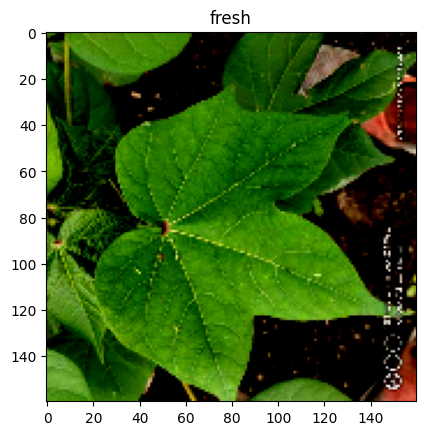

In [ ]:
# Let's look at a one image
IMG_INDEX = 607  # change this to look at other images

plt.imshow(train_images[IMG_INDEX] ,cmap=plt.cm.binary)
plt.title(class_names[train_labels[IMG_INDEX]])
plt.show()

In [ ]:
train_images[0].shape

(160, 160, 3)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_batches = val.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
for image, _ in train_batches.take(1):
   pass

feature_batch = base_model(image)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# before training
val_steps=3

loss0,accuracy0 = model.evaluate(val_batches, steps = val_steps)

3/3 [==============================] - 2s 866ms/step - loss: 0.3699 - accuracy: 0.8854


In [ ]:
# training
initial_epochs = 50

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=val_batches)

acc = history.history['accuracy']
print(acc)

Epoch 1/50
23/23 [==============================] - 18s 747ms/step - loss: 0.3686 - accuracy: 0.8895 - val_loss: 0.3523 - val_accuracy: 0.8899
Epoch 2/50
23/23 [==============================] - 15s 658ms/step - loss: 0.3509 - accuracy: 0.8895 - val_loss: 0.3364 - val_accuracy: 0.8899
Epoch 3/50
23/23 [==============================] - 15s 654ms/step - loss: 0.3347 - accuracy: 0.9021 - val_loss: 0.3232 - val_accuracy: 0.9083
Epoch 4/50
23/23 [==============================] - 15s 665ms/step - loss: 0.3189 - accuracy: 0.9091 - val_loss: 0.3078 - val_accuracy: 0.9083
Epoch 5/50
23/23 [==============================] - 18s 762ms/step - loss: 0.3047 - accuracy: 0.9175 - val_loss: 0.2961 - val_accuracy: 0.9266
Epoch 6/50
23/23 [==============================] - 15s 671ms/step - loss: 0.2908 - accuracy: 0.9217 - val_loss: 0.2849 - val_accuracy: 0.9174
Epoch 7/50
23/23 [==============================] - 15s 663ms/step - loss: 0.2811 - accuracy: 0.9245 - val_loss: 0.2747 - val_accuracy: 0.9266

In [ ]:
model.save('cotton.h5')

1/1 [==============================] - 1s 842ms/step


Prediction: 0.0
Actual: 0


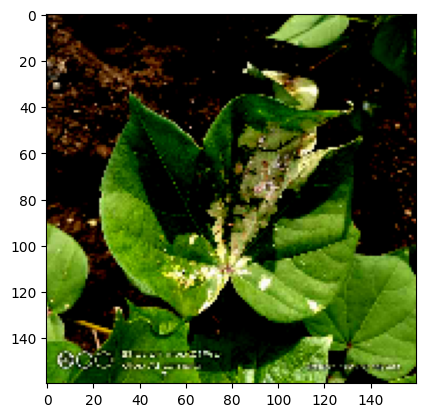

In [ ]:
def predict(index):
  res = model.predict(np.array([test_images[index]]))[0][0] * 2
  print('Prediction:', np.floor(res))
  print('Actual:', test_labels[index])
  plt.imshow(test_images[index], cmap=plt.cm.binary)

predict(3)
# np.array([test_images[0]]).shape